In [1]:
from pymavlink import mavutil
import math
import tkinter as tk
import socket
import time
import helper
import threading

In [2]:
SIM_COMPUTER_IP = '192.168.1.124'  # IP address of the simulation computer
PORT = 15000  # The same port as used by the server

In [3]:
def send_command(command):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((SIM_COMPUTER_IP, PORT))
        s.sendall(command.encode('utf-8'))

def start_instance(instance_id, out_port):
    send_command(f"start {instance_id} {out_port}")

def stop_instance(instance_id):
    send_command(f"stop {instance_id}")

def connect(port):
    connection = mavutil.mavlink_connection(f'udpin:0.0.0.0:{port}') 

    connection.wait_heartbeat() #wait until we hear a heartbeat from the copter

    return connection 

def get_current_position(connection):

    msg = connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)

    north = msg.x
    east = msg.y
    down = -msg.z

    return(north, east, down)

def wait_for_gps_lock(connection, timeout=60):
    start_time = time.time()
    while True:
        # Check for timeout
        if time.time() - start_time > timeout:
            print("Timeout waiting for GPS lock.")
            return False
            
        # Fetch GPS_RAW_INT messages
        msg = connection.recv_match(type='GPS_RAW_INT', blocking=True, timeout=5)
        if not msg:
            print("No GPS data received.")
            continue
            
        # Check for 3D lock
        if msg.fix_type >= 3:
            print(f"GPS lock acquired with {msg.satellites_visible} satellites.")
            return True
        else:
            print(f"Current GPS fix type: {msg.fix_type}, waiting for 3D lock...")

        time.sleep(1)


def arm(mavlink_connection):
    """
    Arms vehicle and fly to a target altitude.
    :param mavlink_connection: The connection to the vehicle
    :param target_altitude: Target altitude in meters
    """

    print("Basic pre-arm checks")
    # Wait for vehicle to initialize and become ready
    while not mavlink_connection.wait_heartbeat(timeout=5):
        print("Waiting for vehicle heartbeat")

           
    print("Setting vehicle to GUIDED mode")
    mavlink_connection.mav.set_mode_send(mavlink_connection.target_system, mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED, 4) 

    # Wait a bit for the mode to change
    time.sleep(2)

    # Copter should arm in GUIDED mode
    mavlink_connection.mav.command_long_send(
        mavlink_connection.target_system, mavlink_connection.target_component,
        mavutil.mavlink.MAV_CMD_COMPONENT_ARM_DISARM,
        0,  # Confirmation
        1,  # 1 to arm
        0, 0, 0, 0, 0, 0  # Unused parameters for this command
    )
def waitForEKF2(connection):
    while True:
        msg = connection.recv_match(type='STATUSTEXT', blocking=True, timeout=5)
        if msg is None:
            continue
        text = msg.text.decode('utf-8')
        if "EKF2 IMU0 is using GPS" in text:
            print("Received EKF2 GPS lock message.")
            return True

def takeoff(mavlink_connection, alt):
    #Assumes you have already set to guided mode and armed.

    mavlink_connection.mav.command_long_send(mavlink_connection.target_system, mavlink_connection.target_component, 
                                 mavutil.mavlink.MAV_CMD_NAV_TAKEOFF, 0, 0, 0, 0, 0, 0, 0, alt)
    
    #See how the copter responded to the takeoff command
    msg = mavlink_connection.recv_match(type = 'COMMAND_ACK', blocking = True)
    print(msg)

    while True:
        # Wait for the next LOCAL_POSITION_NED message
        msg = mavlink_connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)
        
    
        # Check if altitude is within a threshold of the target altitude
        if abs(msg.z * -1 - alt) < 1.0:
            print("Reached target altitude")
            break

#send local frame coordinates and have copter fly over that spot.
def send_waypoint_local(connection, x, y, alt):
    connection.mav.send(mavutil.mavlink.MAVLink_set_position_target_local_ned_message
                    (10, connection.target_system, connection.target_component, mavutil.mavlink.MAV_FRAME_LOCAL_NED, 
                     int(0b010111111000), x, y, alt,
                      0, 0, 0, 0, 0, 0, 0, 0))

    while 1:
        msg = connection.recv_match(type = 'LOCAL_POS', blocking = True)
        print(msg)


starting instance 0 on port 14560starting instance 1 on port 14561

starting instance 2 on port 14562
instance 1 - Heartbeat Recieved!
instance 2 - Heartbeat Recieved!
instance 0 - Heartbeat Recieved!
instance 1 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 2 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 0 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 1 - sending takeoff command
instance 2 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 0 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
Reached target altitude
Instance 1 - North: 0.043477527

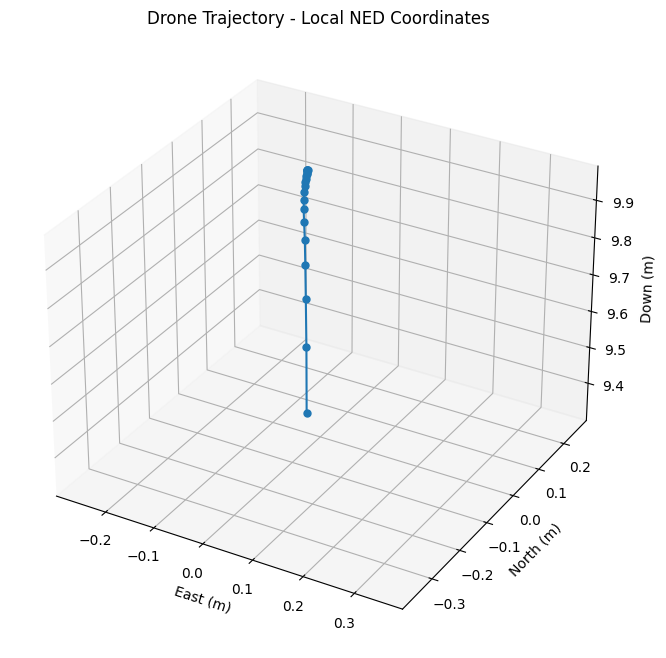

Instance 2 - North: 0.04197029769420624, East: -0.05487455800175667, Down: 9.975849151611328
Instance 0 - North: 0.04147740453481674, East: -0.051182229071855545, Down: 9.977571487426758


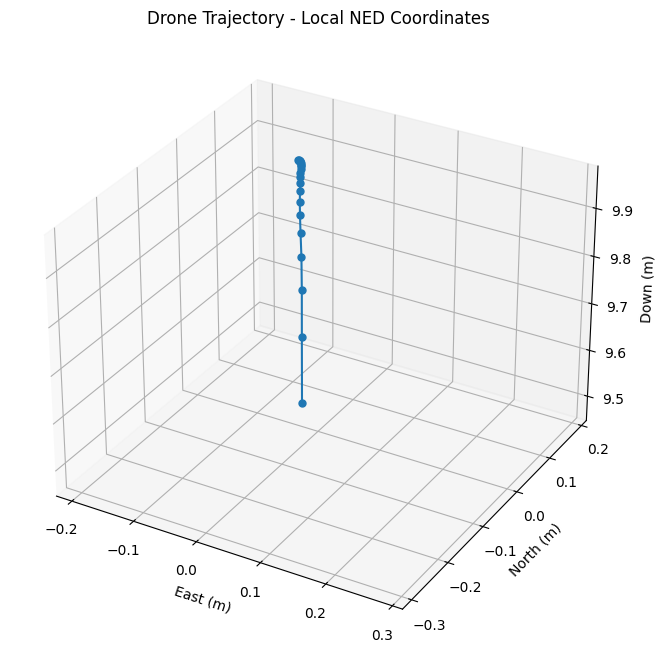

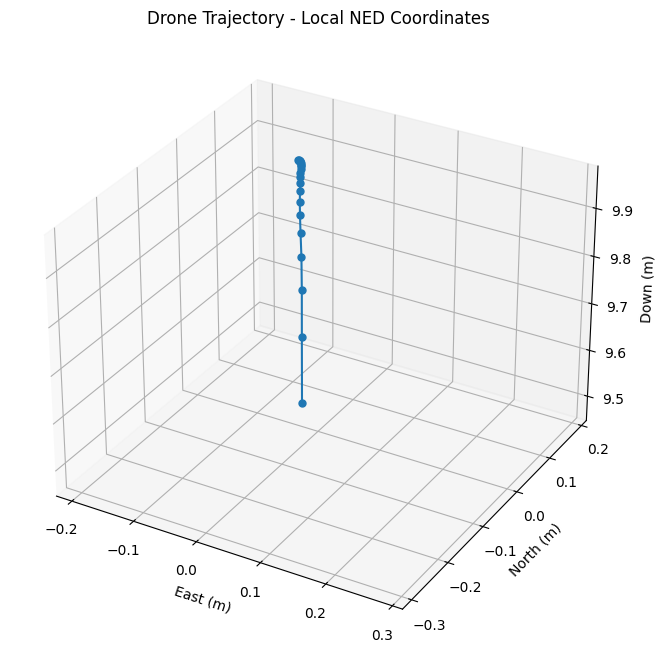

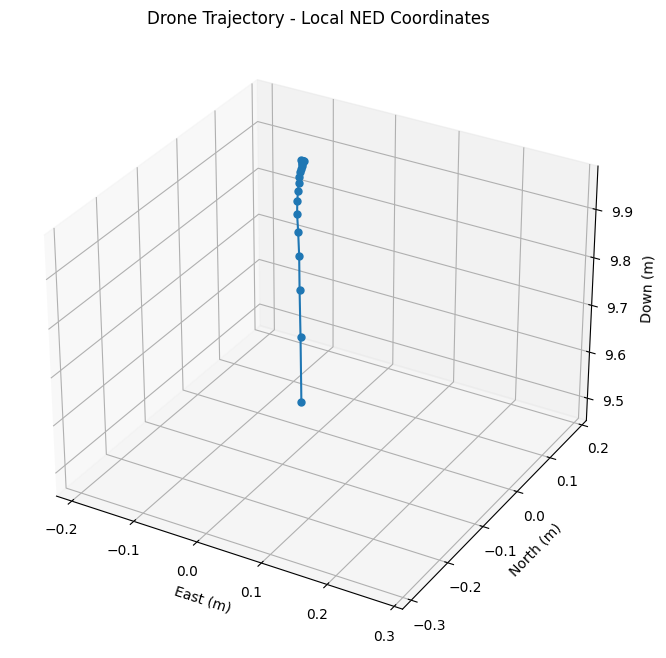

stopping instance 1
stopping instance 2
stopping instance 0


In [4]:
out_port_base = 14560
pid_base = 0
instance_count = 3  # Number of episodes you want to run in each epoch

def drone_operation(pid, out_port):
    print(f"starting instance {pid} on port {out_port}")
    start_instance(pid, out_port)
    drone_connection = connect(out_port)

    # Print heartbeat information
    while True:
        msg = drone_connection.recv_match(type='HEARTBEAT', blocking=True)
        if not msg:
            print(f"instance {pid} - No heartbeat")
        else:
            print(f"instance {pid} - Heartbeat Recieved!")
            break  # or remove to keep listening

    time.sleep(40)

    print(f"instance {pid} - arming throttle in GUIDED mode.")
    arm(drone_connection)

    print(f"instance {pid} - sending takeoff command")
    takeoff(drone_connection, 10)


    for i in range(20):
        north, east, down = get_current_position(drone_connection)
        print(f'Instance {pid} - North: {north}, East: {east}, Down: {down}')
        helper.collect_positions(north, east, down)

    helper.plot_trajectory()
    helper.reset_trajectory()
    time.sleep(1)

    print(f"stopping instance {pid}")
    stop_instance(pid)

def main():
    threads = []
    for i in range(instance_count):
        pid = pid_base + i
        out_port = out_port_base + i
        t = threading.Thread(target=drone_operation, args=(pid, out_port))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

if __name__ == "__main__":
    main()

    